[Source](https://towardsdatascience.com/image-classification-with-tensorflow-2-0-7696e4aa5ca7)

Importing the required libraries:

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from pathlib import Path
import json
from random import randint
from collections import Counter
from collections import defaultdict
import rasterio

import json 
from PIL import Image, ImageDraw
from IPython.display import display
from shapely import wkt
from shapely.geometry.multipolygon import MultiPolygon

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from copy import copy 

%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 30, 30
plt.rcParams['legend.title_fontsize'] = 14

In [6]:
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dropout, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

First, I am insertung the post-fire training image

In [7]:
train_path = '../datasets/train/for_model/train_ready/'
valid_path = '../datasets/train/for_model/val_ready/'
test_path = '../datasets/train/for_model/test_ready/'
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['masks_no_damage_lbl', 'masks_destroyed_lbl'], batch_size=32)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['masks_no_damage_lbl', 'masks_destroyed_lbl'], batch_size=32)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['masks_no_damage_lbl', 'masks_destroyed_lbl'], batch_size=32)

Found 82 images belonging to 2 classes.
Found 21 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


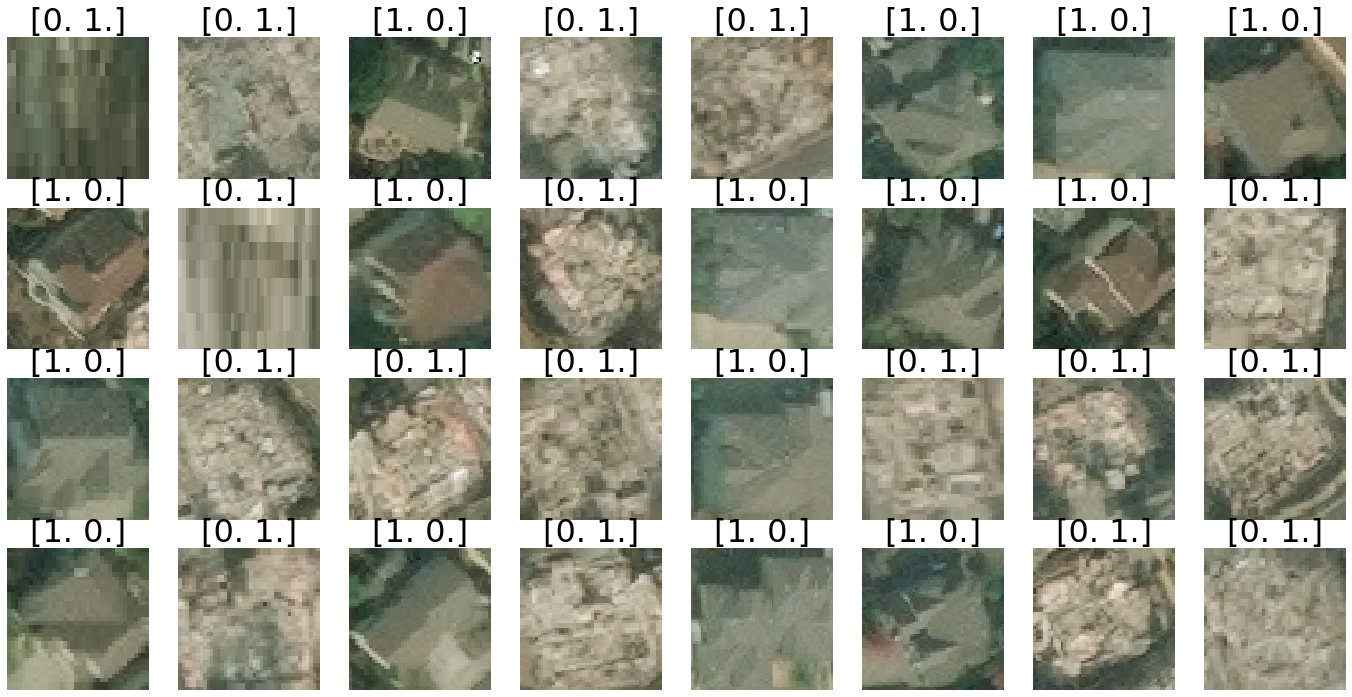

In [8]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(24,12), rows=4, interp=False, titles=None):
    
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=32)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


imgs, labels = next(train_batches)
plots(imgs, titles=labels)


In [9]:
vgg16_model = tensorflow.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


First, let’s disable training on all but the last 4 layers of the pretrained model.

In [10]:
for layer in vgg16_model.layers[:-4]:
    layer.trainable = False

Now, let’s add our own final layers to the network:

In [11]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg16_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 40,407,874
Trainable params: 32,772,610
Non-trainable params: 7,635,264
_________________________________________________________________


There you have it, our own customized model based on VGG16!

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
history = model.fit_generator(
      train_batches,
      steps_per_epoch=train_batches.samples/train_batches.batch_size ,
      epochs=20,
      validation_data=valid_batches,
      validation_steps=valid_batches.samples/valid_batches.batch_size,
      verbose=1)

Epoch 1/20
3/2 [===================================] - 16s 5s/step - loss: 17.2410 - acc: 0.7317 - val_loss: 1.5179 - val_acc: 0.6190
Epoch 2/20
3/2 [===================================] - 13s 4s/step - loss: 0.3050 - acc: 0.8902 - val_loss: 0.8798 - val_acc: 0.6667
Epoch 3/20
3/2 [===================================] - 13s 4s/step - loss: 0.0421 - acc: 1.0000 - val_loss: 0.6056 - val_acc: 0.7619
Epoch 4/20
3/2 [===================================] - 13s 4s/step - loss: 0.0118 - acc: 1.0000 - val_loss: 0.6115 - val_acc: 0.7619
Epoch 5/20
3/2 [===================================] - 13s 4s/step - loss: 0.0077 - acc: 1.0000 - val_loss: 0.5645 - val_acc: 0.7619
Epoch 6/20
3/2 [===================================] - 13s 4s/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.5422 - val_acc: 0.7619
Epoch 7/20
3/2 [===================================] - 13s 4s/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.4786 - val_acc: 0.7619
Epoch 8/20
3/2 [===================================] - 13s 4s/step -

In [17]:
test_imgs, test_labels = next(test_batches)
predictions = model.predict(test_imgs)

## Showing predictions

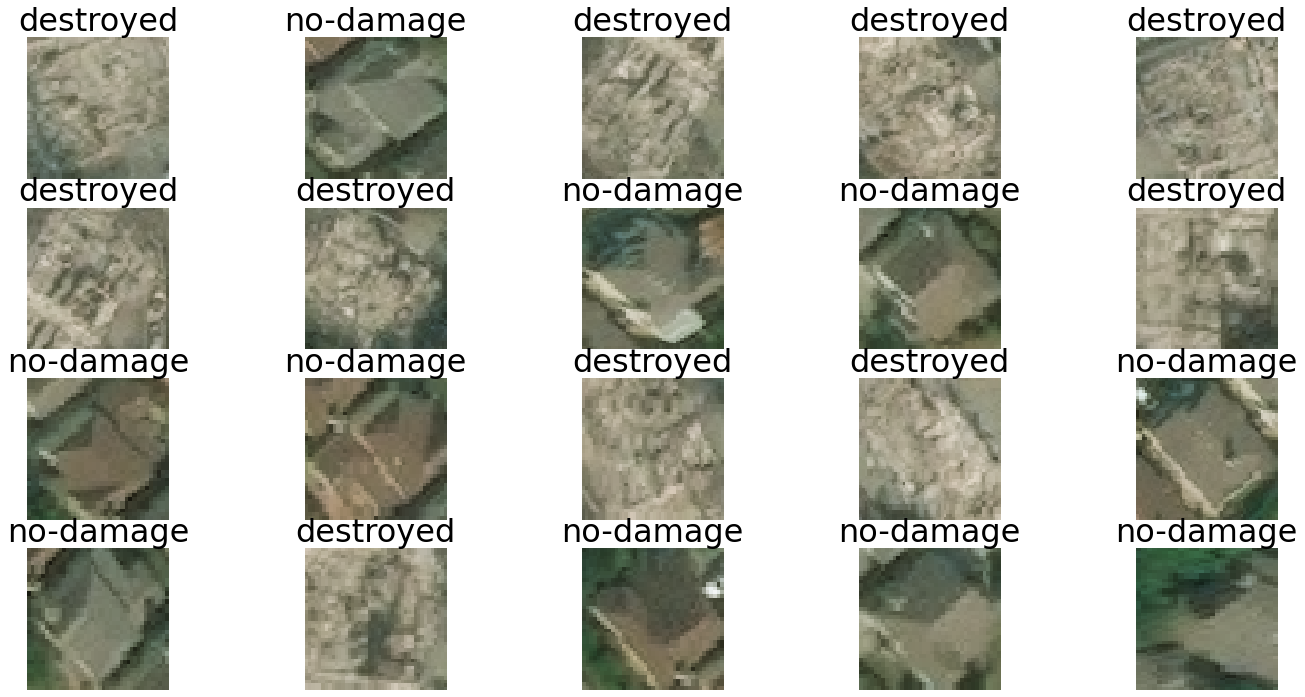

In [18]:
import pandas as pd
def to_label(value):
    if value==0:
        return 'no-damage'
    else:
        return 'destroyed'
test_imgs, test_labels = next(test_batches)
predictions = model.predict(test_imgs)

df = pd.DataFrame()
df['actual'] = test_labels[:,1]
df['predicted'] = np.round(predictions[:,1])
df['predicted_labels']=df['predicted'].map(lambda x: to_label(x))
plots(test_imgs, titles=df['predicted_labels'])

In [19]:
print("Hello World!")

Hello World!
